In [75]:
from wmf import wmf 
import numpy as np
import pylab as pl
import pandas as pnd
import pickle
import datetime
from datetime import timedelta
%matplotlib inline

### Trazado y guardado de cosas básicas de la cuenca

In [76]:
#Trazar cuenca para poder usar SimuBasin.
DEM=wmf.read_map_raster('/media/nicolas/Home/nicolas/01_SIATA/raster/dem_picacha_altavista12m.tif',True)
DIR=wmf.read_map_raster('/media/nicolas/Home/nicolas/01_SIATA/raster/dir_picacha_altavista12m.tif',True)
wmf.cu.nodata=-9999.0; wmf.cu.dxp=12.7
DIR[DIR<=0]=wmf.cu.nodata.astype(int)
DIR=wmf.cu.dir_reclass_rwatershed(DIR,wmf.cu.ncols,wmf.cu.nrows)

In [77]:
#Corriente que pase cerca- punto aguas arriba del usado para trazar la cuenca.
St = wmf.Stream(-75.64028, 6.23114,DEM=DEM,DIR=DIR,name ='Picacha_173')

In [78]:
St.Save_Stream2Map('/media/nicolas/Home/nicolas/01_SIATA/vector/Corr_Picacha_Arriba.shp')

In [79]:
# Trazado de la cuenca - punto de la estacion
cu = wmf.SimuBasin(-75.63973,6.23162, DEM, DIR, name='Picacha_173',
    dt = 300, stream = St, modelType='hills')

In [80]:
#Guardado del shp de la cuenca y la red
cu.Save_Basin2Map('/media/nicolas/Home/nicolas/01_SIATA/vector/Cuenca_LaPicacha173.shp')
cu.Save_Net2Map('/media/nicolas/Home/nicolas/01_SIATA/vector/Red_LaPicacha173.shp', NumTramo=True, umbral=300)

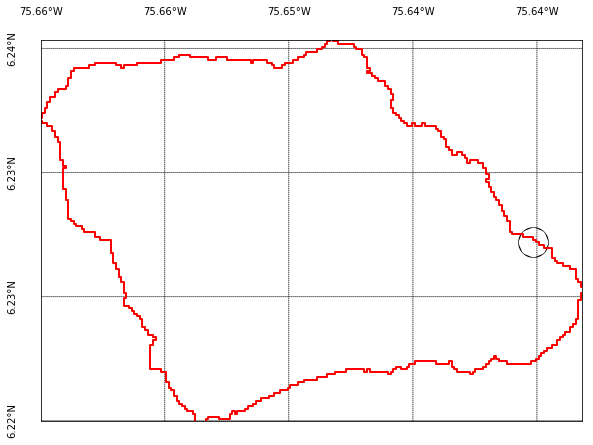

(<mpl_toolkits.basemap.Basemap at 0x7f6520d1fc10>,
 <matplotlib.collections.PathCollection at 0x7f6520cb8510>)

In [81]:
cu.Plot_basin(xy=[-75.63973,6.23162])

In [82]:
#Obtener parámetros geomorfológicos
cu.GetGeo_Cell_Basics()
#como es un modelo por celdas el ancho del canal es igual al largo de la celda.
cu.set_Geomorphology(stream_width=cu.CellLong)

In [83]:
#Parametros morfológicos
cu.GetGeo_Parameters()
cu.GeoParameters

{'Area[km2]': 3.000961615081787,
 'Centro_[X]': -75.650162,
 'Centro_[Y]': 6.2322116,
 'H Cauce_Max [m]': 2340.0,
 'Hmax_[m]': 2552.0,
 'Hmean_[m]': 2172.6304,
 'Hmin_[m]': 1870.0,
 'Long_Cau [km]': 2.5999785156250002,
 'Long_Cuenca [km]': 2.4456980228424072,
 'Pend_Cauce [%]': 15.969183678955945,
 'Pend_Cuenca [%]': 49.191814661026001,
 'Perimetro[km]': 6.1213999080657961}

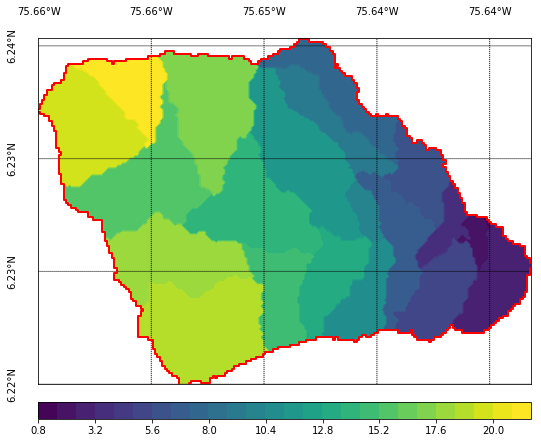

(<mpl_toolkits.basemap.Basemap at 0x7f6520a37850>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6520ac1310>)

In [89]:
cu.Plot_basin(cu.hills_own)

In [182]:
# Atributos que se agregan por ladera - __Load_SimuBasin 
wmf.models.hill_long
wmf.models.hill_slope
wmf.models.stream_slope
wmf.models.stream_long
wmf.models.stream_width
wmf.models.elem_area

array([[   1451.60998535,   29032.19921875,  125483.6171875 ,
          54193.4375    ,  128548.125     ,  102903.015625  ,
         132741.671875  ,  133709.40625   ,  108225.5859375 ,
          36451.5390625 ,  104354.625     ,  261773.65625   ,
         121773.9453125 ,  233870.484375  ,  124515.875     ,
         260967.203125  ,  234838.234375  ,  214838.265625  ,
         275160.71875   ,  208225.375     ,  107903.0078125 ]], dtype=float32)

### Mapas

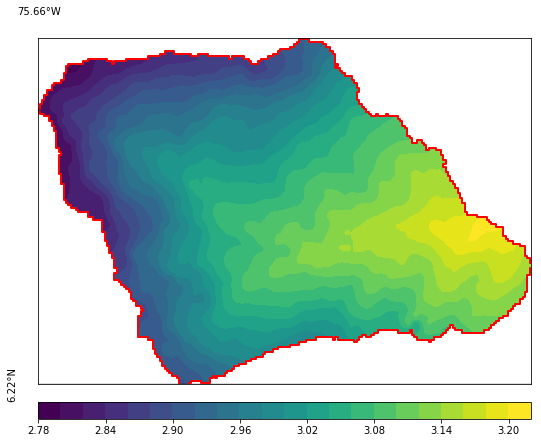

(<mpl_toolkits.basemap.Basemap at 0x7f6521956490>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6521f81510>)

In [67]:
# Evaporación en la cuenca estimada por Turc (?)
Evp=4.658*np.exp(-0.0002*cu.CellHeight)
cu.Plot_basin(Evp,lines_spaces=0.025)

In [68]:
#Lectura de la profunidad de raiz
Z,p = wmf.read_map_raster('/media/nicolas/Home/nicolas/01_SIATA/raster/Prof_raiz_cm.tif')
Z = cu.Transform_Map2Basin(Z,p)
Z[Z == -9999] = 40.0
Z[Z==0]=40

In [69]:
#Profundidad por geomorfologia
Zg = np.zeros(cu.ncells)
Zg[cu.CellSlope<0.25]=0.6
Zg[(cu.CellSlope>=0.25)&(cu.CellSlope<0.30)]=1.0
Zg[(cu.CellSlope>=0.30)&(cu.CellSlope<0.50)]=0.3
Zg[cu.CellSlope>=0.5] = 0.2

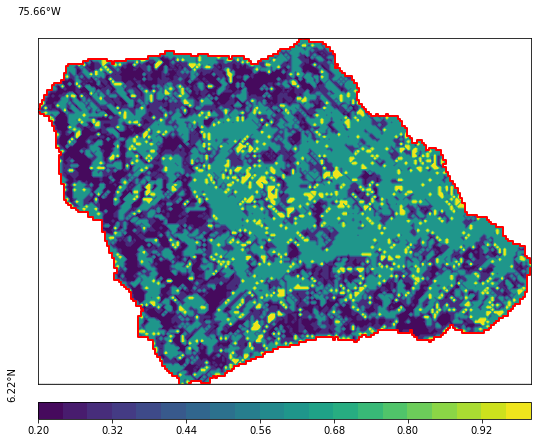

(<mpl_toolkits.basemap.Basemap at 0x7f65217fc4d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f652185ba50>)

In [70]:
cu.Plot_basin(Zg,lines_spaces=0.05)

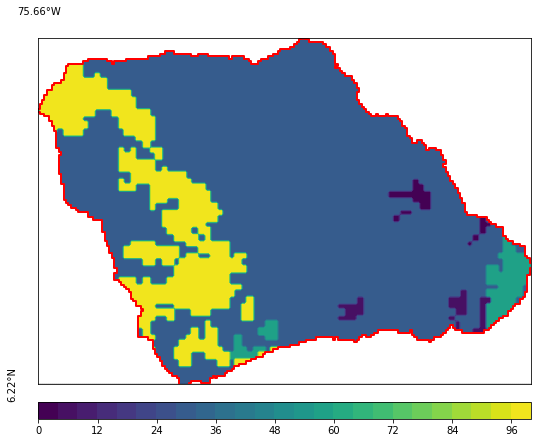

(<mpl_toolkits.basemap.Basemap at 0x7f6520f2ff90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f65210047d0>)

In [71]:
cu.Plot_basin(Z,lines_spaces=0.05)

Contenido volumétrico de agua

In [31]:
Tetas = {}
for i in ['Teta_pmp','Teta_cp','Teta_sat']:
    te,p = wmf.read_map_raster('/media/nicolas/Home/nicolas/01_SIATA/raster/'+i+'.tif')
    te = cu.Transform_Map2Basin(te,p)
    te[te == -9999] = te[te>0].mean()
    te[te == 0] = te[te>0].mean()
    Tetas.update({i:te})

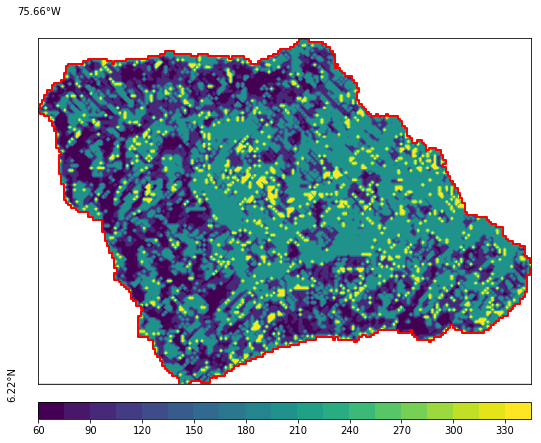

(<mpl_toolkits.basemap.Basemap at 0x7f65283e74d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f65284bd750>)

In [32]:
Hu  = Zg * (Tetas['Teta_cp']-Tetas['Teta_pmp'])*10
Hg  = Zg * (Tetas['Teta_sat']-Tetas['Teta_cp'])*10
cu.Plot_basin(Hg,lines_spaces=0.08)

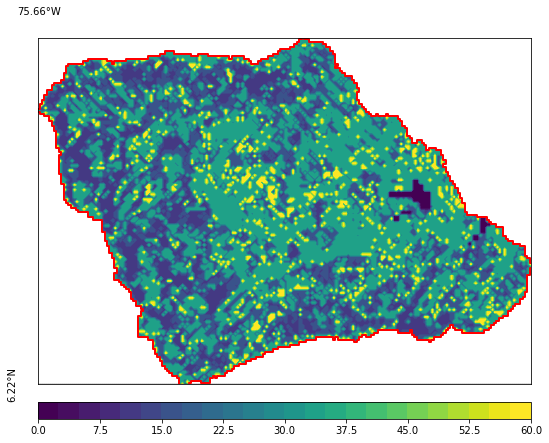

(<mpl_toolkits.basemap.Basemap at 0x7f6522f26550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6522f6bc10>)

In [37]:
Hu[Z == 2] = 2
cu.Plot_basin(Hu,lines_spaces=0.05)

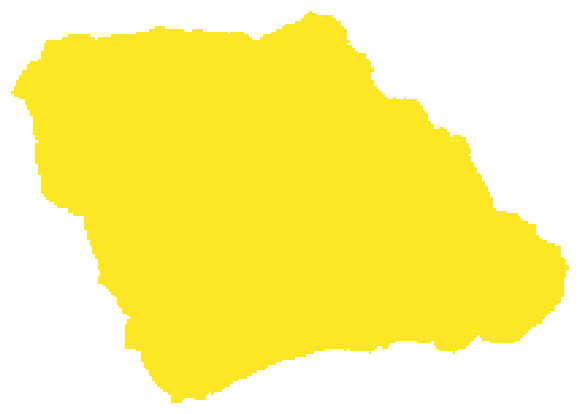

([-75.66084289550781,
  -75.637565334283863,
  6.223906517028809,
  6.2402901225723326],
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6521b1b4d0>)

In [61]:
Ks, p = wmf.read_map_raster('/media/nicolas/Home/nicolas/01_SIATA/raster/'+'Ks_mm_h.tif')
Ks = cu.Transform_Map2Basin(Ks,p)
Ks[Ks == -9999] = Ks[Ks>0].mean()
Ks[Ks == 0] = Ks[Ks>0].mean()
Kp = np.copy(Ks) / 100.0
cu.Plot_basinClean(Ks,cmap=pl.get_cmap('viridis'))

In [190]:
ksh=((Ks/3600000.0)*cu.CellSlope*(30.0**2.0))/(3*(Hg*0.9/1000.0)**2)

In [191]:
kcopy = np.zeros(ksh.shape)
kcopy[(ksh>0) & (ksh<0.05)] = 0.025
kcopy[(ksh>=0.1) & (ksh<0.1)] = 0.05
kcopy[(ksh>=0.1) & (ksh<0.25)] = 0.15
kcopy[(ksh>=0.25) & (ksh<0.5)] = 0.35
kcopy[(ksh>=0.5) & (ksh<0.75)] = 0.6
kcopy[(ksh>=0.5) & (ksh<1.0)] = 0.75
kcopy[(ksh>=1.0) & (ksh<2.0)] = 1.5
kcopy[(ksh>=2.0) & (ksh<3.0)] = 2.0
kcopy[(ksh>=3.0)] = 3.0

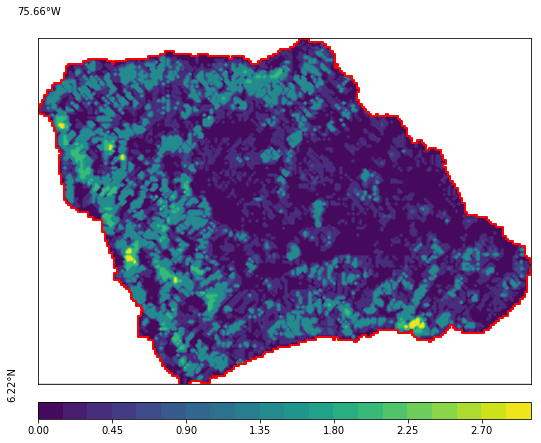

(<mpl_toolkits.basemap.Basemap at 0x7f65203a53d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f651acde850>)

In [192]:
cu.Plot_basin(kcopy,lines_spaces=0.05)

La velocidad en laderas puede ser descrita de dos formas:

- Mediante una ecuación lineal, en la cual no se tiene en cuenta el almacenamiento, en este caso se puede asumir que:
   * $v_{lad} = C_{oef} S_{0}^{1/2}$
- Mediante una ecuación no lineal, en este caso se puede asumir que la velocidad depende del almacenamiento y de características regionales en la cuenca asociadas a los surcos, de acuerdo a Vélez (2001) esto se puede escribir:
   * $v_{lad} = \frac{\xi}{n} A ^{(2/3)e_1} S_{0}^{1/2}$  En este caso $\xi$ y $e_1$ van a variar de acuerdo al tipo de surcos que se asuman, en este aspecto diferentes autores proponen diferentes aproximaciones:
      * $\xi$ puede tomar valores de: 0.5, 0.44, 0.38
      * $e_{1}$ puede tomar valores: 0.64, 0.53, 0.315
      
#### Vel. Laderas lineal

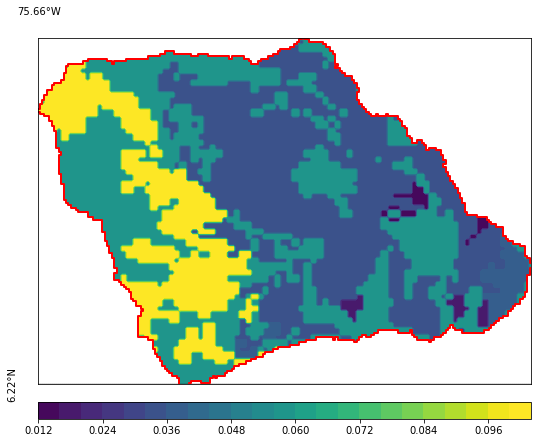

(<mpl_toolkits.basemap.Basemap at 0x7f651a8ed690>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f651a9cddd0>)

In [193]:
man,p = wmf.read_map_raster('/media/nicolas/Home/nicolas/01_SIATA/raster/n_man.asc')
man = cu.Transform_Map2Basin(man,p)
cu.Plot_basin(man,lines_spaces=0.05)

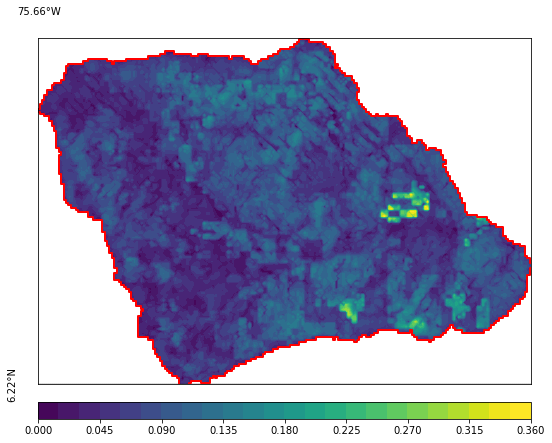

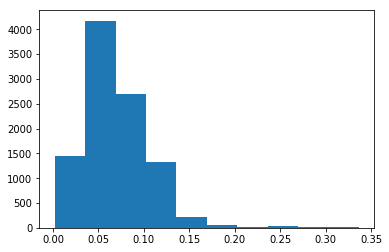

In [194]:
v_lad = (1.41/(man*240))*cu.CellSlope**(1.0/2.0)
cu.Plot_basin(v_lad,lines_spaces=0.05)
pos = np.random.choice(cu.ncells,10000)
h = pl.hist(v_lad[pos])

#### OCG

In [195]:
area = cu.CellAcum * (30**2)/1e6 #Tamaño de celda al cuadrado
CoefOCG,ExpOCG = wmf.OCG_param(pend = cu.CellSlope, area = area)

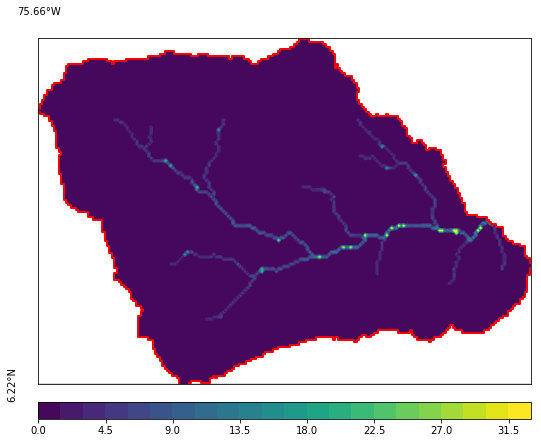

(<mpl_toolkits.basemap.Basemap at 0x7f651a212350>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f651a296cd0>)

In [196]:
cu.Plot_basin(CoefOCG*cu.CellCauce,lines_spaces=0.05)

### Parámetros que no cambian

In [199]:
#Almacenamiento capilar y gravitacional 
cu.set_PhysicVariables('capilar',Hu,0)
cu.set_PhysicVariables('gravit',Hg,1)
#como hay tanque gravitacional, se establece que si hay retorno 
wmf.models.retorno = 1

In [200]:
# Evaporacion, infiltracion, percolacion y perdidas
cu.set_PhysicVariables('v_coef',Evp,0)
#Infiltracion, se hace impermeable la ciudad, se pasa a [mm/seg]
KsForMap = np.copy(Ks)/3600.0
KsForMap.min()
KsForMap[Z==2] = 0.0001
cu.set_PhysicVariables('v_coef',KsForMap,1)
#Percolacion se pasa a [mm/seg]
cu.set_PhysicVariables('v_coef',Kp/3600.0,2)
#Se asume perdidas del sistema iguales a cero 
cu.set_PhysicVariables('v_coef',0,3)

## Guardar .nc no lineal en subsup.

In [213]:
cu.set_Speed_type([2,2,1]) #set lineal todo

In [215]:
#Coloca todas las velocidades en lineal 
cu.set_Speed_type(np.array([2,2,1]))
# Coeficientes de velocidad horizontal 
cu.set_PhysicVariables('h_coef',v_lad,0)
cu.set_PhysicVariables('h_exp',1,0) # Linealiza la ladera de nuevo 
#El flujo sub-superficial se hace no lineal 
cu.set_PhysicVariables('h_coef',ksh,1)
cu.set_PhysicVariables('h_exp',2.0,1)
# Guarda la version lineal 
cu.Save_SimuBasin('/media/nicolas/Home/nicolas/01_SIATA/nc_cuencas/cuenca_Picacha173_hills_v03.nc',
    ruta_dem = '/media/nicolas/Home/nicolas/01_SIATA/raster/dem_picacha_altavista12m.tif',
    ruta_dir = '/media/nicolas/Home/nicolas/01_SIATA/raster/dir_picacha_altavista12m.tif')